# Index   

0. [Importing libraries](##Importing-libraries) 


1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)

 [Reading the data set](###Reading-the-data-set)

2. [Data Enginnering](#Dara-Engineering)
 
3. [Model Screening with Pycaret](#Model-screening-with-PycaretModel-Screening)

4. [Tunning Random Forest Hyperparameters with Optuna](##Random-Forest-Hyperparameters-tunning-with-Optuna)

5. [Prediction of test_X](##test_X-prediction)


1. Import Needed Modules
2. Read in images and create a dataframe of image paths and class labels
3. Trim the train_df dataframe
4. Balance the train_df dataframe
5. Create train, test and validation generators
6. Create a function to show Training Image Samples
7. Create the Model
8. Create a custom Keras callback to continue or halt training
9. Instantiate custom callback and create callbacks to control learning rate and early stopping
10. Train the model
11. Define a function to plot the training data
12. Make predictions on test set, create Confusion Matrix and Classification Report
13. Save the model



### Importing libraries

In [12]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
# pprevent annoying tensorflow warning
'''import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)
warnings.simplefilter("ignore")'''



'import logging\nlogging.getLogger("tensorflow").setLevel(logging.ERROR)\nimport warnings\npd.set_option(\'max_columns\', None)\npd.set_option(\'max_rows\', 90)\nwarnings.simplefilter("ignore")'

In [16]:
from platform import python_version
print(python_version())


3.9.13


In [ ]:
#-----------------------------------------
# DOWNLOAD AND ORGANIZE FLOWERS17 DATASET
#-----------------------------------------
import os
import glob
import datetime
import tarfile
import urllib.request

def download_dataset(filename, url, work_dir):
	if not os.path.exists(filename):
		print("[INFO] Downloading flowers17 dataset....")
		filename, _ = urllib.request.urlretrieve(url + filename, filename)
		statinfo = os.stat(filename)
		print("[INFO] Succesfully downloaded " + filename + " " + str(statinfo.st_size) + " bytes.")
		untar(filename, work_dir)

def jpg_files(members):
	for tarinfo in members:
		if os.path.splitext(tarinfo.name)[1] == ".jpg":
			yield tarinfo

def untar(fname, path):
	tar = tarfile.open(fname)
	tar.extractall(path=path, members=jpg_files(tar))
	tar.close()
	print("[INFO] Dataset extracted successfully.")

#-------------------------
# MAIN FUNCTION
#-------------------------
if __name__ == '__main__':
	flowers17_url  = "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/"
	flowers17_name = "17flowers.tgz"
	train_dir      = "dataset"

	if not os.path.exists(train_dir):
		os.makedirs(train_dir)

	download_dataset(flowers17_name, flowers17_url, train_dir)
	if os.path.exists(train_dir + "\\jpg"):
		os.rename(train_dir + "\\jpg", train_dir + "\\train")


	# get the class label limit
	class_limit = 17

	# take all the images from the dataset
	image_paths = glob.glob(train_dir + "\\train\\*.jpg")

	# variables to keep track
	label = 0
	i = 0
	j = 80

	# flower17 class names
	class_names = ["daffodil", "snowdrop", "lilyvalley", "bluebell", "crocus",
			   	   "iris", "tigerlily", "tulip", "fritillary", "sunflower", 
			       "daisy", "coltsfoot", "dandelion", "cowslip", "buttercup",
			       "windflower", "pansy"]

	# loop over the class labels
	for x in range(1, class_limit+1):
		# create a folder for that class
		os.makedirs(train_dir + "\\train\\" + class_names[label])
		
		# get the current path
		cur_path = train_dir + "\\train\\" + class_names[label] + "\\"
		
		# loop over the images in the dataset
		for index, image_path in enumerate(image_paths[i:j], start=1):
			original_path   = image_path
			image_path      = image_path.split("\\")
			image_file_name = str(index) + ".jpg"
			os.rename(original_path, cur_path + image_file_name)
		
		i += 80
		j += 80
		label += 1

In [9]:
labels = {
        0: 'baseball',
        1: 'cricket',
        2: 'football'
    }

In [ ]:
sdir=r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Image_sports_classification'
, index_col=0)../input/sports-classification'
csvpath=r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Image_sports_classification\sports????.csv'
df=pd.read_csv(csvpath)


In [ ]:
# check for missing values
print('number of missing values in df is =', df.isna().sum().sum())
df.columns=['filepaths', 'labels',  'data_set']
train_df=df.query('data_set== "train"')
test_df=df.query('data_set== "test"')

In [ ]:

valid_df = df.query('data_set== "valid"')
# convert data in filepaths column to the full path to the images
train_df['filepaths']=train_df['filepaths'].apply(lambda x: os.path.join(sdir, x))
test_df['filepaths']=test_df['filepaths'].apply(lambda x: os.path.join(sdir, x))
valid_df['filepaths']=valid_df['filepaths'].apply(lambda x: os.path.join(sdir, x))
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=list(train_df['labels'].unique())
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in train_df['labels'].unique():
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

In [ ]:
def trim(df, max_samples, min_samples):
    '''Trim the df dataframe to max and min samples
    Define the trim function which inputs a dataframe df and returns a trimmed dataframe
    where no class has more samples the max_samples and no class has less than min_samples
    trimming the dataset is useful when it contains more sample images in some classes where
    it has more samples than needed or to few samples for classification purposes.
    this makes it easier to balance the dataset and reduces training time of the model'''
    
    df=df.copy()
    groups=df.groupby('labels')    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby('labels')
    for label in df['labels'].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df


In [ ]:
def balance(df, n, working_dir, img_size):
    ''' Balance the dataset
The balance function defined below takes in a dataframe and an integer n and returns a dataframe
where each class has n samples in each class'''

    df=df.copy()
     # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir) # start with an clean empty directory
    os.mkdir(aug_dir)
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s}'.format(' ', label)
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)        
        df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    return df 

''' EXEMPLE

n=120 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(150,150) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Found 112 validated image filenames.     for class           air hockey           
Found 112 validated image filenames.     for class        ampute football         
Found 99 validated image filenames.      for class         arm wrestling          
Found 113 validated image filenames.     for class          axe throwing          
Found 108 validated image filenames.     for class         baton twirling         
Found 111 validated image filenames.     for class           bike polo            
Found 116 validated image filenames.     for class             boxing             
Found 118 validated image filenames.     for class              gaga              
Found 102 validated image filenames.     for class       horseshoe pitching       
Found 108 validated image filenames.     for class       hydroplane racing        
Found 112 validated image filenames.     for class          ice yachting          
Found 118 validated image filenames.     for class            jousting            
Found 111 validated image filenames.     for class            mushing             
Found 118 validated image filenames.     for class         pole climbing          
Found 112 validated image filenames.     for class          pole dancing          
Found 59 validated image filenames.      for class          sky surfing           
Found 117 validated image filenames.     for class         snow boarding          
Found 99 validated image filenames.      for class            ultimate            
Found 103 validated image filenames.     for class         water cycling          
Found 106 validated image filenames.     for class     wheelchair basketball      
Found 119 validated image filenames.     for class       wheelchair racing        
Found 98 validated image filenames.      for class        wingsuit flying         
Total Augmented images created=  269'''




In [ ]:
# Create the train_gen, test_gen and valid_gen
batch_size=40 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,
                            rotation_range=20, 
                            width_shift_range=.2,
                            height_shift_range=.2,
                            zoom_range=.2 
                            )
t_and_v_gen=ImageDataGenerator()
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths',
                                    y_col='labels', 
                                    target_size=img_size,
                                    class_mode='categorical', 
                                    color_mode='rgb', 
                                    shuffle=True, 
                                    batch_size=batch_size
                                    )
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, 
                                            x_col='filepaths', 
                                            y_col='labels', 
                                            target_size=img_size,
                                            class_mode='categorical', 
                                            color_mode='rgb', 
                                            shuffle=False, 
                                            batch_size=batch_size
                                            )
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
Found 12000 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
test batch size:  50   test steps:  10  number of classes :  100



In [ ]:
def show_image_samples(gen ):
    '''Create a function to show example training images'''

    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [ ]:
#Create a model using transfer learning with EfficientNetB3

'''NOTE experts advise you make the base model initially not trainable. Then train for some number of epochs
then fine tune model by making base model trainable and run more epochs
I have found this to be WRONG!!!!
Making the base model trainable from the outset leads to faster convegence and a lower validation loss
for the same number of total epochs!'''

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
'''Create a custom Keras callback to continue or halt training'''



class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

In [ ]:
# Instantiate custom callback and create 2 callbacks to control learning rate and early stop

epochs=40
ask_epoch=10
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

In [ ]:
#Train the model
'''Note unlike how you are told it is BETTER to make the base model trainable from the outset
It will converge faster and have a lower validation losss'''

history=model.fit(x=train_gen, 
                     epochs=epochs, 
                     verbose=1, 
                     callbacks=callbacks,  
                     validation_data=valid_gen,
                    validation_steps=None,  
                    shuffle=False,  
                    initial_epoch=0
                    )

In [ ]:
def tr_plot(tr_data, start_epoch):


    
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

In [ ]:
def predictor(test_gen, test_steps):
    '''Define a function which takes in a test generator and an integer test_steps
    and generates predictions on the test set including a confusion matric
    and a classification report'''
    
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(16, 10))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    


In [ ]:
#Save the model
  
subject='bengali digits' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 

## 2a Manera

In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train_path = '../input/sports-classification/train'
valid_path = '../input/sports-classification/valid'
test_path = '../input/sports-classification/test'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import  applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Conv1D, MaxPool2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')
import random
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import glob
import shutil
import os
import itertools
from sklearn.metrics import confusion_matrix ,classification_report
# import numpy as np 
# import pandas as pd 
import os
import pathlib
#import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import warnings
warnings.filterwarnings('ignore')
os.environ["KMP_WARNINGS"] = "FALSE" 
from tensorflow.keras import layers
Transfer Learning
train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path,target_size= (224,224),batch_size=10,shuffle=False)
Found 13572 images belonging to 100 classes.
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path,target_size= (224,224),batch_size=10,shuffle=False)
Found 500 images belonging to 100 classes.
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

mobilenet_model = Sequential()
mobilenet_model.add(base)
mobilenet_model.add(GlobalAveragePooling2D())

mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.1))

mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.1))
mobilenet_model.add(Dense(100, activation='softmax'))
2022-02-16 09:07:50.363094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:50.476936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:50.477632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:50.478711: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-16 09:07:50.479574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:50.480230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:50.480874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:52.268808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:52.269632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:52.270260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:52.270857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
9412608/9406464 [==============================] - 0s 0us/step
9420800/9406464 [==============================] - 0s 0us/step
mobilenet_model.summary()
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25700     
=================================================================
Total params: 2,677,412
Trainable params: 419,428
Non-trainable params: 2,257,984
_________________________________________________________________
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
results=mobilenet_model.fit(train_batches,epochs=10)  
2022-02-16 09:07:54.446711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Epoch 1/10
2022-02-16 09:07:57.726453: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
1358/1358 [==============================] - 100s 67ms/step - loss: 3.8587 - accuracy: 0.1648
Epoch 2/10
1358/1358 [==============================] - 39s 28ms/step - loss: 1.8174 - accuracy: 0.5371
Epoch 3/10
1358/1358 [==============================] - 38s 28ms/step - loss: 1.1337 - accuracy: 0.6905
Epoch 4/10
1358/1358 [==============================] - 39s 28ms/step - loss: 0.8724 - accuracy: 0.7543
Epoch 5/10
1358/1358 [==============================] - 39s 29ms/step - loss: 0.6977 - accuracy: 0.7996
Epoch 6/10
1358/1358 [==============================] - 38s 28ms/step - loss: 0.5712 - accuracy: 0.8296
Epoch 7/10
1358/1358 [==============================] - 39s 28ms/step - loss: 0.4902 - accuracy: 0.8528
Epoch 8/10
1358/1358 [==============================] - 39s 29ms/step - loss: 0.4212 - accuracy: 0.8748
Epoch 9/10
1358/1358 [==============================] - 39s 28ms/step - loss: 0.3493 - accuracy: 0.8974
Epoch 10/10
1358/1358 [==============================] - 39s 29ms/step - loss: 0.3070 - accuracy: 0.9119
mobilenet_model.evaluate(test_batches)
50/50 [==============================] - 4s 69ms/step - loss: 0.2401 - accuracy: 0.9220
[0.24005533754825592, 0.921999990940094]

In [2]:
#Data exploration & manipulation
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import seaborn as sns
import matplotlib.style as style 
import datetime as dt
import os
import matplotlib.pyplot as plt

#ML Models search and optimisation
from pycaret.classification import * 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import optuna
from sklearn.model_selection import cross_val_score

%matplotlib inline

# Exploratory Data Analysis


In [3]:
# Import space_X_train.csv
space_X_train = pd.read_csv(r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Hackathon_Talent_Squad\initial_docs\space_X_train.csv', index_col=0)

In [4]:
space_X_train.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


In [5]:
space_X_train.isnull().sum()

sensor_1    0
sensor_2    0
sensor_3    0
sensor_4    0
sensor_5    0
sensor_6    0
target      0
dtype: int64

In [6]:
space_X_train.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229,1.980476
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791,1.410537
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189,0.000000
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944,1.000000
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754,2.000000
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593,3.000000
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324,4.000000


Values of sensors are very similar (range from -0.433 to 6.700). There is no null values to be cleaned.

In [7]:
y = space_X_train.target

Text(0, 0.5, '# of instances')

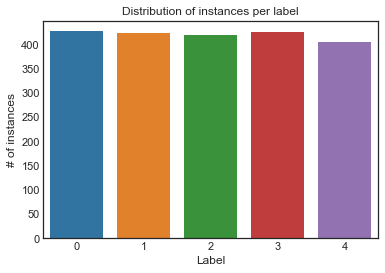

In [8]:

#Label distribution checking
sns.set_context("notebook")
style.use('seaborn-white')    
counter = Counter(y)
dist_plot=sns.barplot(x=list(counter.keys()), y=list(counter.values()))
dist_plot.set_title('Distribution of instances per label')
dist_plot.set_xlabel('Label')
dist_plot.set_ylabel('# of instances')

In [9]:
ratio_labels= [x/len(y) for x in list(counter.values())]
ratio_labels

[0.19285714285714287,
 0.20333333333333334,
 0.20142857142857143,
 0.20285714285714285,
 0.19952380952380952]

Distribution of samples are very similiar each other, there is no minoritay/majotary class in the label column.

Let's have a look on the data:

Text(0.5, 0.98, 'Pair plot of sensors with status label differentiation')

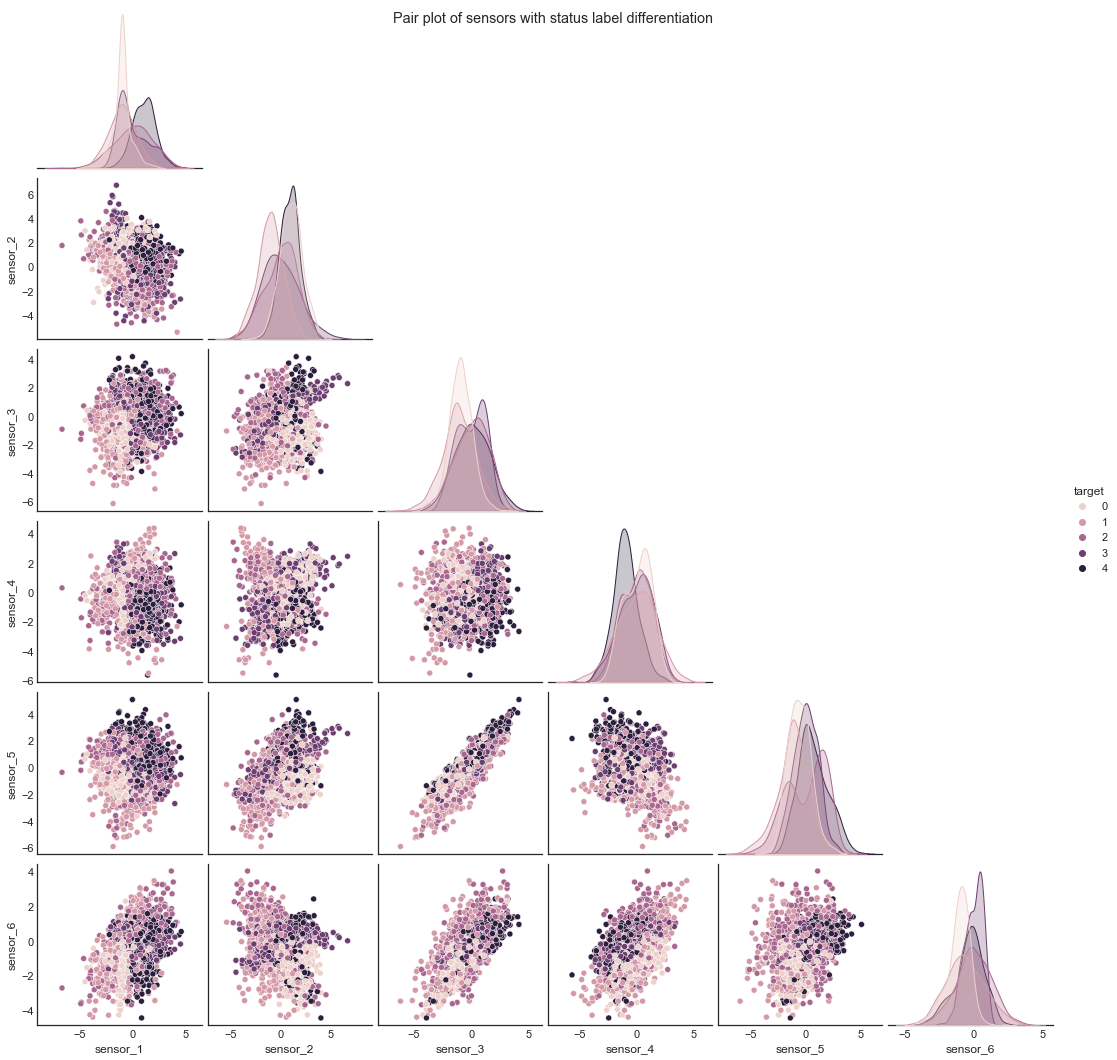

In [10]:
pairplot_sensors = sns.pairplot(space_X_train, corner=True,hue='target')
pairplot_sensors.fig.suptitle('Pair plot of sensors with status label differentiation')

From the previous graph it can be concluded that:
* Each class has a gaussian type distribution.
* The different labels form clusters for certain sensors, such differences are the ground of predictions.

Text(0.5, 1.0, 'Correlation of values of different sensors')

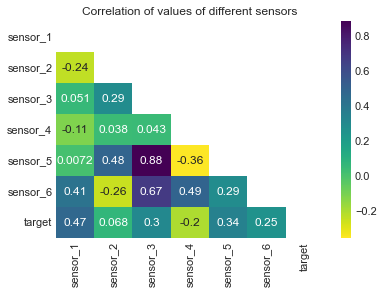

In [11]:
# Getting the Lower Triangle of the co-relation matrix
matrix = np.triu(space_X_train.corr())
sheatmap_correlations_sensors = sns.heatmap(space_X_train.corr(), annot=True, cmap='viridis_r', mask=matrix)
sheatmap_correlations_sensors.set_title('Correlation of values of different sensors')

Sensors 3 and 5 are highly correlated but it does not involve a correlation with the differents labels/status.

# Dara Engineering

There is no need to clean, and it may be tried some data engineering of the Data set. Let's consider to check normalization, standarization and treating outliers with robustscaler:

In [12]:
space_X_train.columns

Index(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'target'],
      dtype='object')

In [13]:
x = space_X_train.drop('target',axis=1).values #returns a numpy array
numerical_cols=['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6']


In [14]:

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
space_X_train_min_max_scaled = pd.DataFrame(x_scaled)


In [16]:

scaler = preprocessing.RobustScaler()
space_X_train_robust = scaler.fit_transform(x)
space_X_train_robust = pd.DataFrame(space_X_train_robust, columns =numerical_cols)


In [17]:

scaler = preprocessing.StandardScaler()
space_X_train_standard = scaler.fit_transform(x)
space_X_train_standard = pd.DataFrame(space_X_train_standard, columns =numerical_cols)


In [18]:
space_X_train_min_max_scaled ['target'] = space_X_train['target']
space_X_train_robust ['target'] = space_X_train['target']
space_X_train_standard ['target'] = space_X_train['target']


# Model screening with Pycaret

With Pycaret we test the dataframe with several models to check its performance with :

In [29]:
setup(space_X_train,
          target='target',
    )
best_model_rfc=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7720,0.9442,0.7731,0.7782,0.7713,0.7149,0.7165,0.6110
et,Extra Trees Classifier,0.7638,0.9441,0.7642,0.7689,0.7633,0.7047,0.7060,0.4480
lightgbm,Light Gradient Boosting Machine,0.7576,0.9421,0.7583,0.7643,0.7563,0.6970,0.6990,0.4440
gbc,Gradient Boosting Classifier,0.7393,0.9355,0.7402,0.7442,0.7375,0.6740,0.6760,1.2480
knn,K Neighbors Classifier,0.7365,0.9226,0.7367,0.7435,0.7355,0.6705,0.6726,0.1100
dt,Decision Tree Classifier,0.6753,0.7969,0.6750,0.6792,0.6738,0.5939,0.5954,0.0330
ada,Ada Boost Classifier,0.5834,0.8237,0.5858,0.5857,0.5669,0.4794,0.4853,0.2110
nb,Naive Bayes,0.5698,0.8373,0.5710,0.5670,0.5558,0.4621,0.4674,0.0270
qda,Quadratic Discriminant Analysis,0.5398,0.8382,0.5381,0.5779,0.5371,0.4243,0.4326,0.0280
lr,Logistic Regression,0.5160,0.7913,0.5171,0.4877,0.4886,0.3949,0.4010,0.0520


In [32]:
print(best_model_rfc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=6041, verbose=0,
                       warm_start=False)


Let's try with the data modified with data engineering: MinMaxScaler, Standarization and RobustScaler. 

In [33]:
setup(space_X_train_min_max_scaled,
          target='target', 
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7550,0.9404,0.7544,0.7584,0.7544,0.6935,0.6945,0.5400
et,Extra Trees Classifier,0.7522,0.9381,0.7522,0.7544,0.7510,0.6901,0.6911,0.4690
rf,Random Forest Classifier,0.7440,0.9394,0.7441,0.7463,0.7428,0.6799,0.6810,0.6030
gbc,Gradient Boosting Classifier,0.7393,0.9360,0.7391,0.7423,0.7382,0.6739,0.6751,1.3990
knn,K Neighbors Classifier,0.7236,0.9184,0.7224,0.7267,0.7216,0.6541,0.6556,0.1150
dt,Decision Tree Classifier,0.6535,0.7833,0.6532,0.6537,0.6513,0.5666,0.5675,0.0280
qda,Quadratic Discriminant Analysis,0.6318,0.8985,0.6326,0.6702,0.6080,0.5396,0.5541,0.0270
nb,Naive Bayes,0.5643,0.8351,0.5631,0.5665,0.5462,0.4544,0.4616,0.0290
ada,Ada Boost Classifier,0.5596,0.8026,0.5603,0.5542,0.5458,0.4491,0.4536,0.2230
lda,Linear Discriminant Analysis,0.5058,0.7856,0.5071,0.4823,0.4770,0.3820,0.3891,0.0280


In [34]:
print(best_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4396, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [35]:
setup(space_X_train_standard,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7550,0.9407,0.7549,0.7573,0.7539,0.6936,0.6946,0.5200
rf,Random Forest Classifier,0.7502,0.9420,0.7501,0.7520,0.7488,0.6876,0.6886,0.5910
lightgbm,Light Gradient Boosting Machine,0.7474,0.9350,0.7472,0.7493,0.7462,0.6842,0.6852,0.4850
knn,K Neighbors Classifier,0.7325,0.9219,0.7318,0.7380,0.7303,0.6654,0.6674,0.1360
gbc,Gradient Boosting Classifier,0.7223,0.9306,0.7227,0.7225,0.7193,0.6528,0.6542,1.4000
dt,Decision Tree Classifier,0.6616,0.7884,0.6618,0.6635,0.6599,0.5769,0.5781,0.0270
ada,Ada Boost Classifier,0.5630,0.8151,0.5657,0.5541,0.5473,0.4540,0.4587,0.2050
qda,Quadratic Discriminant Analysis,0.5534,0.8527,0.5513,0.5719,0.5395,0.4411,0.4505,0.0240
nb,Naive Bayes,0.5507,0.8348,0.5502,0.5524,0.5362,0.4378,0.4434,0.0240
lr,Logistic Regression,0.5221,0.7870,0.5231,0.4918,0.4884,0.4024,0.4099,0.0510


In [36]:
print(best_model)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1623, verbose=0,
                     warm_start=False)


In [37]:
setup(space_X_train_robust,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7611,0.9482,0.7601,0.7661,0.7607,0.7012,0.7024,0.6610
et,Extra Trees Classifier,0.7583,0.9467,0.7578,0.7654,0.7584,0.6979,0.6994,0.4980
lightgbm,Light Gradient Boosting Machine,0.7522,0.9412,0.7519,0.7588,0.7524,0.6903,0.6916,0.5350
knn,K Neighbors Classifier,0.7372,0.9238,0.7362,0.7438,0.7360,0.6714,0.6732,0.1150
gbc,Gradient Boosting Classifier,0.7277,0.9385,0.7265,0.7327,0.7268,0.6596,0.6610,1.3300
dt,Decision Tree Classifier,0.6616,0.7886,0.6601,0.6675,0.6600,0.5769,0.5788,0.0310
qda,Quadratic Discriminant Analysis,0.5854,0.8656,0.5859,0.6242,0.5774,0.4819,0.4932,0.0280
ada,Ada Boost Classifier,0.5705,0.8170,0.5684,0.5589,0.5535,0.4624,0.4672,0.2460
nb,Naive Bayes,0.5528,0.8406,0.5506,0.5506,0.5393,0.4405,0.4453,0.0250
lr,Logistic Regression,0.5003,0.7957,0.4989,0.4806,0.4690,0.3748,0.3811,0.0480


In [39]:
print(best_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=8858, verbose=0,
                       warm_start=False)


## Random Forest Hyperparameters tunning with Pycaret

In [40]:
def scoring_f1(y_test,X_test,method): #generation of f1 macro
    '''
    Funtion to get the f1_macro metric 
    Input: 
        y_test = real target label of the data set used
        X_test = features used to determine the label target
        method = model evaluated which will predict the target labels
    Output:
        Float number corresponding to the F1_macro.'''

    f1score=f1_score(y_test,
                     method.predict(X_test),
                     average= 'macro'
)        
    return f1score  

To avoid data leakage in Pycaret, the model to be tuned will be created with the train set:

In [42]:
X=space_X_train.copy()
y=X.target


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,stratify=y)
X_train.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
19,-1.153663,-0.490551,-1.221787,1.198523,-1.645471,-0.397307,1
807,0.051587,-2.850896,-1.648007,1.069979,-2.540411,0.311744,2
974,-1.615734,-0.396239,-0.605161,0.191728,-0.660267,-0.590922,1
1746,1.700228,0.049878,-0.189630,-1.797814,0.570287,-0.449787,4
905,-1.906572,-0.770195,-2.545250,0.390334,-2.492019,-1.664043,1


In [44]:
setup(X_train,
          target='target'
    )
    
best_model2=compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7468,0.9405,0.7461,0.7513,0.7452,0.6834,0.6852,0.5810
et,Extra Trees Classifier,0.7449,0.9407,0.7439,0.7488,0.7435,0.6810,0.6825,0.4670
lightgbm,Light Gradient Boosting Machine,0.7296,0.9321,0.7289,0.7352,0.7278,0.6619,0.6641,0.5040
gbc,Gradient Boosting Classifier,0.7160,0.9287,0.7153,0.7190,0.7133,0.6449,0.6467,1.0880
knn,K Neighbors Classifier,0.7087,0.9179,0.7070,0.7128,0.7060,0.6355,0.6376,0.1390
dt,Decision Tree Classifier,0.6589,0.7869,0.6569,0.6643,0.6573,0.5733,0.5752,0.0350
nb,Naive Bayes,0.5644,0.8299,0.5609,0.5611,0.5481,0.4544,0.4602,0.0260
qda,Quadratic Discriminant Analysis,0.5589,0.8443,0.5566,0.5845,0.5561,0.4480,0.4541,0.0300
ada,Ada Boost Classifier,0.5490,0.8032,0.5473,0.5488,0.5373,0.4354,0.4398,0.2000
lr,Logistic Regression,0.5390,0.7878,0.5397,0.5173,0.5118,0.4234,0.4301,1.7080


In [45]:
model_rf_pycaret = best_model2
X_test.drop('target', axis=1, inplace=True) #target column should be removed
print (f' score f1-macro of Random Forest Classifier with Pycaret = {scoring_f1(y_test,X_test,model_rf_pycaret)}')

 score f1-macro of Random Forest Classifier with Pycaret = 0.7704753873647545


In [46]:
# train model
rf_model = create_model('rf')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7477,0.9277,0.7475,0.7507,0.7459,0.6848,0.6864
1,0.7658,0.9560,0.7655,0.7680,0.7642,0.7072,0.7086
2,0.7545,0.9290,0.7525,0.7594,0.7549,0.6932,0.6941
3,0.8091,0.9541,0.8092,0.8100,0.8079,0.7612,0.7619
4,0.7273,0.9365,0.7293,0.7470,0.7293,0.6593,0.6635
5,0.8000,0.9621,0.7976,0.8020,0.7981,0.7498,0.7511
6,0.7636,0.9408,0.7613,0.7655,0.7615,0.7041,0.7055
7,0.7000,0.9279,0.7006,0.7099,0.6968,0.6253,0.6287
8,0.7000,0.9445,0.6977,0.7010,0.6954,0.6246,0.6270
9,0.7000,0.9269,0.6994,0.6992,0.6977,0.6247,0.6255


In [47]:
print (f' score f1 of rf created by Pycaret not tunned = {scoring_f1(y_test,X_test,rf_model)}') 

 score f1 of rf created by Pycaret not tunned = 0.7704753873647545


In [48]:
# tune model
tuned_rf_model = tune_model(rf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6937,0.9166,0.6930,0.6951,0.6864,0.6172,0.6207
1,0.7297,0.9477,0.7292,0.7328,0.7192,0.6619,0.6671
2,0.7182,0.9307,0.7165,0.7189,0.7140,0.6477,0.6495
3,0.7818,0.9535,0.7819,0.7873,0.7804,0.7270,0.7291
4,0.7000,0.9258,0.7025,0.7053,0.6993,0.6253,0.6269
5,0.7727,0.9591,0.7686,0.7788,0.7688,0.7154,0.7187
6,0.7000,0.9310,0.6991,0.7021,0.6940,0.6249,0.6279
7,0.6364,0.9091,0.6364,0.6382,0.6321,0.5454,0.5477
8,0.7364,0.9458,0.7341,0.7421,0.7271,0.6699,0.6747
9,0.6364,0.9165,0.6347,0.6375,0.6313,0.5451,0.5477


In [49]:
print (f' Score f1 of Random Forest by Pycaret and Tuned = {scoring_f1(y_test,X_test,tuned_rf_model)}') 

 Score f1 of Random Forest by Pycaret and Tuned = 0.7581663867854406


The initial model worked better than the tunned one regarding the f1_macro metric. 

## Random Forest Hyperparameters tunning with Optuna

In [50]:
import optuna

In [51]:
X=space_X_train.copy()
y=X.target
X.drop('target',axis=1, inplace=True)

In [53]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=853, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=853, verbose=0,
                       warm_start=False)

In [54]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,stratify=y)
    
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 100000)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 100000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 20)
    
    rf_cl = RandomForestClassifier(bootstrap = bootstrap, 
                                   max_depth = max_depth, 
                                   max_features = max_features,
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


In [55]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-06-26 20:00:17,119] A new study created in memory with name: no-name-f354c721-de52-49aa-8fe8-c3e126dfaa8c
[I 2022-06-26 20:00:33,468] Trial 0 finished with value: 0.6944346189671327 and parameters: {'bootstrap': 'True', 'max_depth': 98086, 'max_features': 'sqrt', 'max_leaf_nodes': 56019, 'n_estimators': 272, 'n_jobs': 9}. Best is trial 0 with value: 0.6944346189671327.
[I 2022-06-26 20:01:06,076] Trial 1 finished with value: 0.6968323235815257 and parameters: {'bootstrap': 'True', 'max_depth': 14643, 'max_features': 'sqrt', 'max_leaf_nodes': 79281, 'n_estimators': 980, 'n_jobs': 4}. Best is trial 1 with value: 0.6968323235815257.
[I 2022-06-26 20:01:30,796] Trial 2 finished with value: 0.7006636708743464 and parameters: {'bootstrap': 'True', 'max_depth': 83487, 'max_features': 'auto', 'max_leaf_nodes': 89112, 'n_estimators': 537, 'n_jobs': 9}. Best is trial 2 with value: 0.7006636708743464.
[I 2022-06-26 20:01:54,849] Trial 3 finished with value: 0.698613854694117 and parameter

In [56]:
import plotly.io as pio #To fix an issue with the renderer of graphs in VSC
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [57]:
pio.renderers.default = "notebook_connected"

In [58]:
optuna.visualization.plot_param_importances(study).show()

In [59]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [60]:
study.best_params

{'bootstrap': 'False',
 'max_depth': 54402,
 'max_features': 'log2',
 'max_leaf_nodes': 94905,
 'n_estimators': 386,
 'n_jobs': 12}

In [61]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 20)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-26 20:20:28,497] Trial 20 finished with value: 0.7123444049418926 and parameters: {'max_depth': 9942, 'max_leaf_nodes': 3487, 'n_estimators': 768, 'n_jobs': 18}. Best is trial 20 with value: 0.7123444049418926.
[I 2022-06-26 20:20:40,757] Trial 21 finished with value: 0.7186746447752783 and parameters: {'max_depth': 9357, 'max_leaf_nodes': 3165, 'n_estimators': 287, 'n_jobs': 20}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:21:01,993] Trial 22 finished with value: 0.7100951202679731 and parameters: {'max_depth': 9932, 'max_leaf_nodes': 3272, 'n_estimators': 793, 'n_jobs': 20}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:21:21,580] Trial 23 finished with value: 0.7100951202679731 and parameters: {'max_depth': 9791, 'max_leaf_nodes': 3202, 'n_estimators': 800, 'n_jobs': 20}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:21:42,500] Trial 24 finished with value: 0.7084582865272788 and parameters: {'max_depth': 9730,

In [62]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [63]:
optuna.visualization.plot_param_importances(study).show()

In [64]:
study.best_params

{'max_depth': 9357, 'max_leaf_nodes': 3165, 'n_estimators': 287, 'n_jobs': 20}

In [65]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 20000)
    n_estimators =  trial.suggest_int('n_estimators', 100, 2000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 6)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-26 20:27:34,134] Trial 40 finished with value: 0.7119181952228647 and parameters: {'max_depth': 9832, 'max_leaf_nodes': 4235, 'n_estimators': 1153, 'n_jobs': 6}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:28:12,283] Trial 41 finished with value: 0.7159418791502521 and parameters: {'max_depth': 9868, 'max_leaf_nodes': 4037, 'n_estimators': 1589, 'n_jobs': 6}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:28:54,413] Trial 42 finished with value: 0.7139458335801552 and parameters: {'max_depth': 9765, 'max_leaf_nodes': 4024, 'n_estimators': 1505, 'n_jobs': 6}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:29:53,618] Trial 43 finished with value: 0.7181364961274778 and parameters: {'max_depth': 9845, 'max_leaf_nodes': 4010, 'n_estimators': 1539, 'n_jobs': 6}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:30:39,056] Trial 44 finished with value: 0.7187116610994758 and parameters: {'max_depth': 9986,

In [66]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [67]:
optuna.visualization.plot_param_importances(study).show()

In [68]:
study.best_params

{'max_depth': 9950, 'max_leaf_nodes': 4591, 'n_estimators': 1669, 'n_jobs': 6}

In [69]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1000, 5000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 200, 800)
    n_jobs =  trial.suggest_int('n_jobs', 2, 6)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-26 20:40:02,959] Trial 60 finished with value: 0.7100951202679731 and parameters: {'max_depth': 4011, 'max_leaf_nodes': 4018, 'n_estimators': 794, 'n_jobs': 6}. Best is trial 51 with value: 0.7203964156214397.
[I 2022-06-26 20:40:14,241] Trial 61 finished with value: 0.7147170994201375 and parameters: {'max_depth': 4193, 'max_leaf_nodes': 4050, 'n_estimators': 327, 'n_jobs': 6}. Best is trial 51 with value: 0.7203964156214397.
[I 2022-06-26 20:40:21,562] Trial 62 finished with value: 0.7175300946995377 and parameters: {'max_depth': 3153, 'max_leaf_nodes': 4087, 'n_estimators': 276, 'n_jobs': 6}. Best is trial 51 with value: 0.7203964156214397.
[I 2022-06-26 20:40:28,114] Trial 63 finished with value: 0.704872752493182 and parameters: {'max_depth': 1661, 'max_leaf_nodes': 4055, 'n_estimators': 215, 'n_jobs': 6}. Best is trial 51 with value: 0.7203964156214397.
[I 2022-06-26 20:40:42,146] Trial 64 finished with value: 0.7102040967209421 and parameters: {'max_depth': 4905, 'max

In [70]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [71]:
optuna.visualization.plot_param_importances(study).show()

In [ ]:
study.optimize(objective, n_trials=10)

In [ ]:
study.optimize(objective, n_trials=10)


[I 2022-06-22 21:50:46,089] Trial 117 finished with value: 0.7209692523524147 and parameters: {'max_depth': 4032, 'max_leaf_nodes': 9445, 'n_estimators': 281, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:50:53,034] Trial 118 finished with value: 0.7175300946995377 and parameters: {'max_depth': 4014, 'max_leaf_nodes': 9424, 'n_estimators': 276, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:51:01,442] Trial 119 finished with value: 0.7192498090050643 and parameters: {'max_depth': 4020, 'max_leaf_nodes': 9318, 'n_estimators': 280, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:51:08,604] Trial 120 finished with value: 0.7152246576635225 and parameters: {'max_depth': 4040, 'max_leaf_nodes': 9262, 'n_estimators': 292, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:51:16,973] Trial 121 finished with value: 0.717389587355369 and parameters: {'max_depth': 4017,

In [ ]:
study.optimize(objective, n_trials=10)

[I 2022-06-22 21:54:30,871] Trial 138 finished with value: 0.7196780727604631 and parameters: {'max_depth': 4084, 'max_leaf_nodes': 9242, 'n_estimators': 266, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:54:37,726] Trial 139 finished with value: 0.717602381847563 and parameters: {'max_depth': 4119, 'max_leaf_nodes': 9240, 'n_estimators': 268, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:54:46,338] Trial 140 finished with value: 0.7176169363377707 and parameters: {'max_depth': 4061, 'max_leaf_nodes': 9318, 'n_estimators': 264, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:54:53,524] Trial 141 finished with value: 0.7196780727604631 and parameters: {'max_depth': 4045, 'max_leaf_nodes': 9321, 'n_estimators': 269, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:55:01,519] Trial 142 finished with value: 0.7157421601978676 and parameters: {'max_depth': 4101,

In [ ]:
study.best_params

{'max_depth': 3770, 'max_leaf_nodes': 9507, 'n_estimators': 274, 'n_jobs': 2}

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
study.best_params

{'max_depth': 2511, 'max_leaf_nodes': 9249, 'n_estimators': 610, 'n_jobs': 2}

The best f1_macro reached tunning with Optuna is 0,721.

## test_X prediction

The initial Pycaret screening done with the whole training data set(which also gave Random Forset as best model) is the best model to be used with the x_test data set as it has been trained with all the data available to predict the X_test.

Charge test_X dataset to be predicted. We check its statistically ressemblance to the training data set.:

In [130]:
test_x=pd.read_csv(r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Hackathon_Talent_Squad\initial_docs\space_X_test.csv',index_col=0)

test_x.isnull().sum()

sensor_1    0
sensor_2    0
sensor_3    0
sensor_4    0
sensor_5    0
sensor_6    0
dtype: int64

In [131]:
test_x.shape

(900, 6)

In [133]:
test_x.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,-0.170339,0.135481,-0.447035,-0.201708,-0.263349,-0.445490
std,1.485402,1.547202,1.394437,1.487102,1.450823,1.215000
min,-5.084203,-4.292548,-4.628992,-6.732089,-5.196997,-4.823971
25%,-1.098759,-0.934171,-1.460497,-1.163163,-1.182667,-1.152891
50%,-0.386297,0.341427,-0.464239,-0.177710,-0.233699,-0.410182
75%,0.881170,1.246296,0.626893,0.870332,0.679282,0.399597
max,4.636012,4.612113,3.299946,5.996929,3.917118,5.357953


test_X is very similar to the training set.

In [134]:
x_test_pred = best_model_rfc.predict(test_x)
x_test_pred

array([1, 3, 2, 0, 3, 2, 4, 0, 2, 3, 1, 4, 3, 1, 4, 4, 4, 3, 2, 0, 1, 2,
       4, 0, 0, 3, 0, 2, 2, 4, 2, 2, 4, 3, 3, 1, 0, 4, 3, 0, 4, 2, 3, 2,
       2, 0, 0, 1, 0, 4, 4, 0, 1, 0, 4, 4, 1, 3, 3, 0, 3, 0, 3, 0, 4, 0,
       1, 0, 2, 3, 0, 1, 4, 0, 4, 0, 0, 1, 2, 3, 4, 3, 0, 3, 1, 1, 2, 3,
       1, 2, 2, 4, 1, 1, 0, 1, 4, 2, 1, 4, 0, 0, 0, 4, 2, 4, 4, 4, 1, 2,
       4, 1, 3, 3, 3, 0, 3, 4, 2, 2, 0, 4, 4, 3, 1, 2, 4, 1, 3, 2, 2, 1,
       4, 0, 0, 2, 3, 0, 0, 4, 0, 4, 3, 2, 1, 3, 4, 3, 4, 4, 1, 2, 1, 2,
       0, 4, 2, 4, 4, 2, 0, 2, 3, 3, 1, 4, 1, 3, 2, 0, 1, 2, 4, 4, 1, 2,
       3, 0, 3, 4, 2, 1, 0, 4, 2, 2, 3, 3, 4, 1, 1, 1, 2, 4, 0, 0, 4, 4,
       1, 2, 0, 2, 4, 3, 2, 2, 3, 1, 1, 3, 0, 0, 2, 1, 1, 3, 4, 2, 2, 1,
       2, 3, 2, 0, 3, 0, 0, 2, 2, 3, 0, 2, 4, 3, 4, 4, 0, 3, 3, 3, 1, 4,
       3, 0, 2, 0, 2, 2, 2, 0, 4, 3, 1, 3, 1, 1, 0, 3, 2, 4, 2, 1, 0, 2,
       2, 4, 2, 4, 1, 2, 1, 4, 2, 0, 3, 0, 1, 4, 2, 4, 1, 1, 3, 1, 2, 4,
       0, 0, 2, 2, 3, 1, 0, 2, 0, 0, 4, 4, 1, 3, 0,

In [135]:
predictions_df=pd.DataFrame(x_test_pred,columns=['final_status'])
predictions_df

,final_status
0,1
1,3
2,2
3,0
4,3
...,...
895,3
896,4
897,0
898,3


In [137]:
predictions_df.to_csv(r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Hackathon_Talent_Squad\predictions.csv',index=False)

In [138]:
pip list > requirements.txt #generates file with all packages installed in the environment used

Note: you may need to restart the kernel to use updated packages.
